### Config

In [1]:
import csv
import requests
import json
import urllib.request
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from nltk.corpus import stopwords
dutch_stopwords = stopwords.words("dutch")
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='


In [2]:
!python --version
!jupyter --version

Python 3.10.1
Selected Jupyter core packages...
IPython          : 8.0.0
ipykernel        : 6.6.1
ipywidgets       : 7.6.5
jupyter_client   : 7.1.0
jupyter_core     : 4.9.1
jupyter_server   : 1.13.2
jupyterlab       : 3.2.7
nbclient         : 0.5.9
nbconvert        : 6.4.0
nbformat         : 5.1.3
notebook         : 6.4.7
qtconsole        : not installed
traitlets        : 5.1.1


In [3]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }

# Court Case Scraper

### Config

In [15]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }


### Old Methods

Method to extract the text from the casefiles. Search the uitsprakenBaseURL with case ID to get the html file. 
Filter through the html file with BeautifulSoup and look for either class 'uitspraak' or 'conclusie' as the standard seems to switch between cases. 
Parse html file to textfile to get a clean text file. Replace \n and commas with empty strings.

In [4]:
def getCaseText(caseId):
    response = requests.get(uitsprakenBaseUrl + caseId)
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_content = soup.find("div", {"id": 'content'})
    uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    if soup_content.find('div', {'class': 'uitspraak'}) is not None:
        uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    elif soup_content.find('div', {'class': 'conclusie'}) is not None:
        uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
    uitspraak = uitspraak_html.get_text()
    uitspraak = uitspraak.replace(',', '')
    return uitspraak

Method to parse each case individually. Save case attributes to cases.csv and save each case text to a .txt file in /data/ folder and name it the case ID.

In [5]:
def parseCaseInfo(results):
    global cases_df
    for case in results:
        caseText = getCaseText(case['TitelEmphasis'])
        parsedId = case['TitelEmphasis'].replace(':', '-') # Case id's apparentlyl use ':'. We cannot save files with ':' in the name, so we replace them with '-'.
        f= open(save_text_location + parsedId + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
        f.write(caseText)
        case['Case ID'] = parsedId
        cases_df = cases_df.append(case, ignore_index = True)
        print('Processed case', case['Case ID'])
    cases_df.to_csv('cases3.csv', index=False)

Method to retrieve raw data from the backend. Backend url is at the top in the Config. files = complete request payload the backend expects to receive. 


In [ ]:
def queryUitspraak():
    print("Querying")
    files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":searchQuery,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }
    try:
        response = requests.post(baseUrl, json=files)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records!")
        parseCaseInfo(results)
    except urllib.error.HTTPError as err:
        print(err) 

queryUitspraak()

### Methods

Get cases from https://uitspraken.rechtspraak.nl/api/zoek.
Returns a collection of dictionaries.

In [19]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records found.")
        return results
    except urllib.error.HTTPError as err:
        print(err)   

Create a dataframe of all queried cases with the following columns: 
- Id
- Verdict date
- Publication date
- Verdict type
- Jurisdiction type

In [20]:
def create_cases_df(cases):
    cases_df = pd.DataFrame(columns = index)
    cases_df = pd.DataFrame(columns = index)
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True)
    cases_df.to_csv('./court case data/testdata.csv', index=False)
    return cases_df
            

Save the text of all cases from the dataframe to a .txt file located in /data folder. 

In [21]:
def save_case_text(df):
#     case_count = len(df)
    i = 1
    for case in df["id"]:
        try:
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            if soup_content.find('div', {'class': 'uitspraak'}) is not None:
                uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            elif soup_content.find('div', {'class': 'conclusie'}) is not None:
                uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
            uitspraak = uitspraak_html.get_text()
            uitspraak = uitspraak.replace(',', '')
            parsed_id = case.replace(":", "-")
            f= open(save_text_location + parsed_id + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
            f.write(uitspraak)
#             print(f"{i}/{case_count} {parsed_id}")
#             clear_output(wait=True)
#             i += 1
        except Exception as e:
            print(f"Error in saving. {e}")
    print("Finished")
            

### Create dataset

In [8]:
cases = get_cases(files)
cases_df = create_cases_df(cases)
# save_case_text(cases_df)


18177 records found.


In [9]:
def clean_string(dirty):
    
    clean_str = dirty.strip()
    clean_str = clean_str.lower()
    
    return clean_str

In [11]:
def save_case_text(df):
    for i in range(len(df)):
#         case_id = df.iloc[i]['id'].replace('-', ':')
        case_id = 'ECLI:NL:RBZWB:2020:2646'
        print(f"\n CASE: {case_id} \n")
        try:
            response = requests.get(complete_case_url + case_id)
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            if df.iloc[i]['verdict_type'] == 'uitspraak':
                statement_content = soup_content.find('div', {'class': 'uitspraak'})
            elif df.iloc[i]['verdict_type'] == 'conclusie':
                statement_content = soup_content.find('div', {'class': 'conclusie'})
            
            sections = {}
            for el in statement_content.find_all(attrs={'class': 'section'}):
                section_title = clean_string(el.find('h2').text)
                print(section_title)
                sections[section_title] = el
                
#             print(sections.keys())
#             print(sections['8 De beslissing'].text)
            
            
           
        except Exception as e:
            print(f"Error in saving: {e}")

            
save_case_text(cases_df[:1])


 CASE: ECLI:NL:RBZWB:2020:2646 

1 onderzoek van de zaak
2 de tenlastelegging
3 de voorvragen
4 de beoordeling van het bewijs
5 de strafbaarheid
6 de strafoplegging
7 de wettelijke voorschriften
8 de beslissing
9 bijlage i
2
hij op of omstreeks 22 oktober 2019 te tilburg opzettelijk aanwezig heeft gehad ongeveer 57,5 liter amfetamine(-olie), in elk geval een hoeveelheid van een materiaal bevattende amfetamine, zijnde amfetamine een middel als bedoeld in de bij de opiumwet behorende lijst i, dan wel aangewezen krachtens het vijfde lid van artikel 3a van die wet;(art 10 lid 3 opiumwet, art 2 ahf/ond c opiumwet)
10 bijlage ii


In [12]:
%%time
save_case_text(cases_df[:1])


 CASE: ECLI:NL:RBZWB:2020:2646 

1 onderzoek van de zaak
2 de tenlastelegging
3 de voorvragen
4 de beoordeling van het bewijs
5 de strafbaarheid
6 de strafoplegging
7 de wettelijke voorschriften
8 de beslissing
9 bijlage i
2
hij op of omstreeks 22 oktober 2019 te tilburg opzettelijk aanwezig heeft gehad ongeveer 57,5 liter amfetamine(-olie), in elk geval een hoeveelheid van een materiaal bevattende amfetamine, zijnde amfetamine een middel als bedoeld in de bij de opiumwet behorende lijst i, dan wel aangewezen krachtens het vijfde lid van artikel 3a van die wet;(art 10 lid 3 opiumwet, art 2 ahf/ond c opiumwet)
10 bijlage ii
CPU times: user 98.1 ms, sys: 3.8 ms, total: 102 ms
Wall time: 696 ms


In [8]:
%%time
cases_df_1 = cases_df[:5000]
cases_df_2 = cases_df[5000:10000]
cases_df_3 = cases_df[10000:15000]
cases_df_4 = cases_df[15000:]

print(len(cases_df_1))
print(len(cases_df_2))

t1 = Thread(target=save_case_text ,args=(cases_df_1,))
t2 = Thread(target=save_case_text ,args=(cases_df_2,))
t3 = Thread(target=save_case_text ,args=(cases_df_3,))
t4 = Thread(target=save_case_text ,args=(cases_df_4,))


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

print("finished")

5000
5000
Finished
Finished
Finished
Finished
finished
CPU times: total: 13min 23s
Wall time: 26min 8s


# Create / Filter dataset

### Update Dataset

Create updated csv with all relevant cases

In [22]:
cases = get_cases(files)
cases_df = create_cases_df(cases)


18178 records found.


In [23]:
print(cases_df)

                              id verdict_date publication_date verdict_type  \
0        ECLI-NL-RBNNE-2021-5018   01-10-2021       23-11-2021    uitspraak   
1      ECLI-NL-RBZUT-2003-AH9598   03-06-2003       09-07-2003    uitspraak   
2        ECLI-NL-RBZWB-2020-2646   23-06-2020       23-06-2020    uitspraak   
3        ECLI-NL-GHAMS-2019-1601   08-05-2019       26-07-2019    uitspraak   
4        ECLI-NL-GHAMS-2019-1602   08-05-2019       26-07-2019    uitspraak   
...                          ...          ...              ...          ...   
18173    ECLI-NL-RBAMS-2013-1294   29-01-2013       08-10-2013    uitspraak   
18174      ECLI-NL-PHR-2020-1106   24-11-2020       24-11-2020    conclusie   
18175    ECLI-NL-GHAMS-2017-2618   29-06-2017       05-07-2017    uitspraak   
18176  ECLI-NL-RBAMS-2013-BZ0392   29-01-2013       01-02-2013    uitspraak   
18177  ECLI-NL-GHAMS-2007-BB2447   13-07-2007       29-08-2007    uitspraak   

      jurisdiction_type  
0          [Strafrecht]  

In [24]:
dataPath = os.getcwd() + '/court case data/testdata/'

list_of_cases = cases_df['id'].tolist()
list_of_created_cases = [case.replace('.txt', '') for case in os.listdir(dataPath)]
list_to_create = [case for case in list_of_cases if case not in list_of_created_cases]
if len(list_to_create) > 0:
    print(f"Creating {len(list_to_create)} new cases.")
    df_to_save = cases_df[cases_df['id'].isin(list_to_create)]
    save_case_text(df_to_save)
    print("Done")

Creating 104 new cases.
Finished
Done


### Create and clean full dataframe

Create:

In [4]:
dataPath = os.getcwd() + '/court case data/testdata/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=["id", "case text"])
cases_df = pd.read_csv('./court case data/testdata.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])


No file DS_Store


In [5]:
print(merged_df.columns)

Index(['id', 'verdict_date', 'publication_date', 'verdict_type',
       'jurisdiction_type', 'case text'],
      dtype='object')


Clean:

In [6]:
total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    try:
        length = len(currtext.split())
    except:
        print('Please update the dataset')
    total_len_uncleaned += length
print(f"Total words in uncleaned dataset: {total_len_uncleaned}")

Total words in uncleaned dataset: 85732001


In [50]:
cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))
print("Done")

Done


In [51]:
total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


Original count: 85979057 
 Cleaned count: 51491142 
 Difference: 34487915
40.11% decrease


### Creating some plots and metrics

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Strafrecht'),
  Text(1, 0, 'Civiel recht'),
  Text(2, 0, 'Verbintenissenrecht'),
  Text(3, 0, 'Bestuursrecht'),
  Text(4, 0, 'Belastingrecht'),
  Text(5, 0, 'Materieel strafrecht'),
  Text(6, 0, 'Personen- en familierecht'),
  Text(7, 0, 'Ambtenarenrecht'),
  Text(8, 0, 'Socialezekerheidsrecht'),
  Text(9, 0, 'Insolventierecht'),
  Text(10, 0, 'Penitentiair strafrecht'),
  Text(11, 0, 'Bestuursprocesrecht'),
  Text(12, 0, 'Arbeidsrecht'),
  Text(13, 0, 'Burgerlijk procesrecht'),
  Text(14, 0, 'Europees strafrecht'),
  Text(15, 0, 'Omgevingsrecht'),
  Text(16, 0, 'Internationaal strafrecht'),
  Text(17, 0, 'Internationaal publiekrecht'),
  Text(18, 0, 'Strafprocesrecht')])

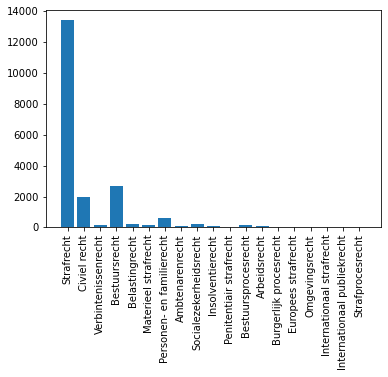

In [49]:
jurisdiction_types_dict = {
    "Strafrecht": 0,
    "Civiel recht": 0,
    "Verbintenissenrecht": 0,
    "Bestuursrecht": 0,
    "Belastingrecht": 0,
    "Materieel strafrecht": 0,
    "Civiel recht": 0,
    "Personen- en familierecht": 0,
    "Ambtenarenrecht": 0,
    "Socialezekerheidsrecht": 0,
    "Insolventierecht": 0,
    "Penitentiair strafrecht": 0,
    "Bestuursprocesrecht": 0,
    "Arbeidsrecht": 0,
    "Burgerlijk procesrecht": 0,
    "Europees strafrecht": 0,
    "Omgevingsrecht": 0,
    "Internationaal strafrecht": 0,
    "Internationaal publiekrecht": 0,
    "Strafprocesrecht": 0
}

# print(cleaned_df.jurisdiction_type.unique())
for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    for j in jurisdiction_types_dict.keys():
        if j in curr['jurisdiction_type']:
            jurisdiction_types_dict[j] = jurisdiction_types_dict[j] + 1

plt.bar(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.values()), align='center')
plt.xticks(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.keys()))
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Verdict type counts')

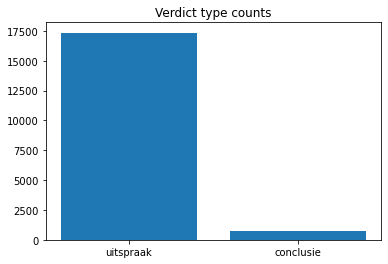

In [50]:
verdict_types = cleaned_df.verdict_type.unique()
verdict_types_counts = [cleaned_df['verdict_type'].value_counts()[0], cleaned_df['verdict_type'].value_counts()[1]]

plt.bar(verdict_types, verdict_types_counts)
plt.title('Verdict type counts')


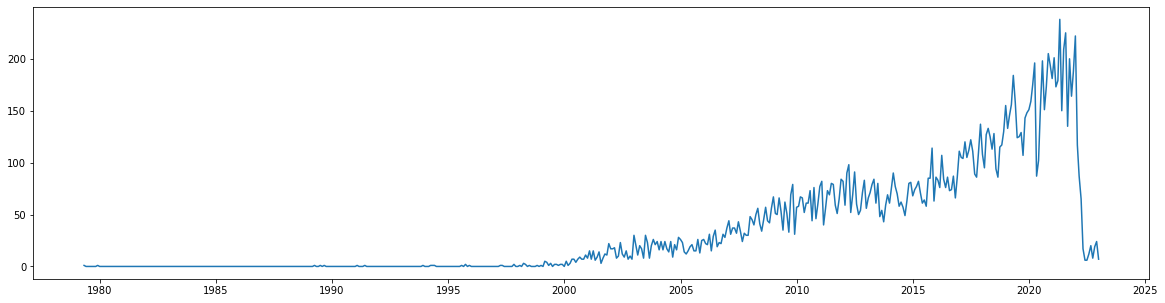

In [51]:
plt.rcParams["figure.figsize"] = (20,5)

cleaned_df_date_plot = cleaned_df["verdict_date"].value_counts().resample("1M").sum()
plt.plot(cleaned_df_date_plot)

In [52]:
print(cleaned_df["verdict_date"].value_counts())

2019-10-17    29
2017-11-16    26
2021-04-22    24
2020-09-16    23
2020-03-12    23
              ..
2015-06-06     1
2020-04-06     1
2008-12-22     1
2004-10-03     1
2006-10-16     1
Name: verdict_date, Length: 4224, dtype: int64


### Filter for trafficking keywords

In [52]:
print(f"Original case count: {len(cleaned_df)}")

trafficking_df = pd.DataFrame()
# trafficking_words = ["smokkel", "transport", "invoer", "import", "export", " uitvoer "]
trafficking_words = ["smokkel", "transport", "invoer", "import", "export"]

# trafficking_words = ["smokkel", "transport"]


for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    if any(x in curr["case text"] for x in trafficking_words):
        trafficking_df = trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(trafficking_df)} articles.")

Original case count: 18178
Filtered for trafficking:  3858 articles.


In [54]:
def get_links(df):
    link_list = []
    for i in range(len(df)):
        curr = df.iloc[i]
        link = complete_case_url + curr['id'].replace('-', ':')
        link_list.append(link)
    print(link_list)

In [ ]:
get_links(trafficking_df)

In [34]:
print(trafficking_df[-20:])

                                               case text  \
18146  Procureur-Generaal Hoge Raad Nederlanden mr. P...   
18148  Nr. 09/04465 09/04512 Mr. L. Timmerman Parket ...   
18149  30 juni 1998 Strafkamer nr. 107.189 LD Hoge Ra...   
18151  Afdeling strafrecht Parketnummer : 20-003610-1...   
18152  201607055/2/A3 Datum: 24 januari 2018 Staatsra...   
18153  Afdeling strafrecht Parketnummer: 21-000878-11...   
18154  RECHTBANK NOORD-HOLLAND Afdeling Publiekrecht ...   
18155  Parketnummer : 20-001226-18 Uitspraak : 16 apr...   
18156  PROCUREUR-GENERAAL BIJ DE HOGE RAAD DER NEDERL...   
18157  RECHTBANK ZEELAND-WEST-BRABANT Strafrecht Zitt...   
18161  conclusie COLLEGE VAN BEROEP VOOR HET BEDRIJFS...   
18162  RECHTBANK LIMBURG Zittingsplaats Roermond Stra...   
18163  Parketnummer : 20-002588-20 Uitspraak : 28 jan...   
18165  Nr. 00119/03 Mr Machielse Zitting 8 juli 2003 ...   
18172  Rechtbank Den Haag Sector Strafrecht Meervoudi...   
18173  RECHTBANK AMSTERDAM VONNIS 13/529

In [31]:
countries_df = pd.read_csv('dutch-countries.csv', encoding = "ISO-8859-1")
countries_list = list(countries_df["Countries"])
# countries_list.remove('Nederland')

In [32]:
countries = []
for i in range(len(trafficking_df)):
    curr_text = trafficking_df.iloc[i]['case text']
    curr_countries = []
    for j in countries_list:
        if j in curr_text:
            curr_countries.append(j)
    countries.append(curr_countries)
    
trafficking_df['countries'] = countries

In [33]:
print(trafficking_df[-20:]['countries'])

18146                   [Duitsland , Luxemburg, Nederland]
18148    [Duitsland , Frankrijk, Japan, Nederland, Sing...
18149    [België, Frankrijk, Hongarije, Italië, Luxembu...
18151    [Australië, Nederland, Nieuw-Zeeland, Verenigd...
18152          [Frankrijk, Griekenland, Nederland, Zweden]
18153          [Duitsland , Nederland, Slowakije, Turkije]
18154    [Colombia, Dominica, Ecuador, Marokko, Nederla...
18155    [België, Canada, Colombia, Dominica, Dominicaa...
18156         [Duitsland , Hongarije, Nederland, Roemenië]
18157    [België, Duitsland , Kenia, Nederland, Verenig...
18161    [België, Duitsland , Finland, Frankrijk, Ierla...
18162    [België, Colombia, Dominica, Dominicaanse Repu...
18163    [Duitsland , Frankrijk, India, Nederland, Paki...
18165    [België, Frankrijk, Iran, Israël, Japan, Neder...
18172     [Colombia, Duitsland , Monaco, Nederland, Niger]
18173    [Colombia, Italië, Japan, Marokko, Nederland, ...
18174    [België, Bulgarije, Italië, Nederland, Verenig.

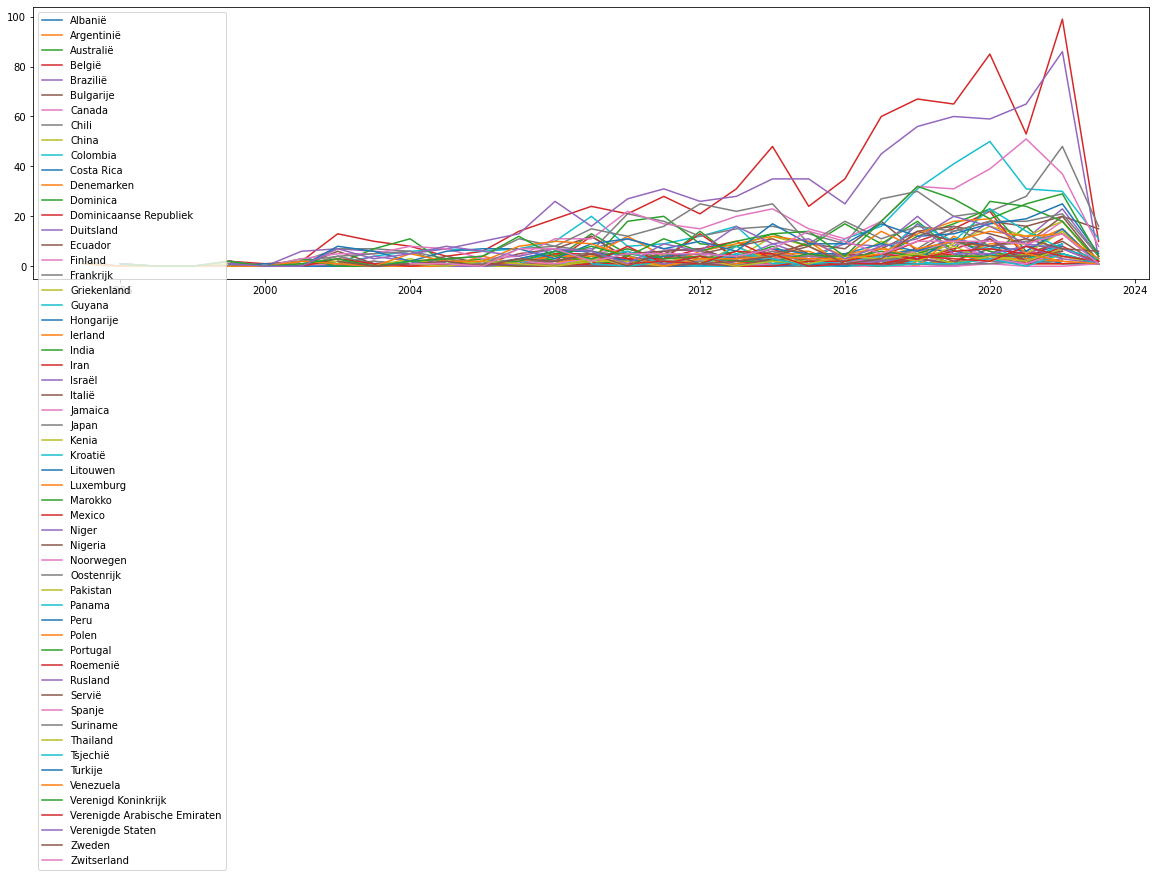

In [130]:
from collections import Counter

resample = "1Y"
index = cleaned_df["verdict_date"].value_counts().resample(resample).sum().index

complete_country_count_df = pd.DataFrame(index=index)
for i in countries_list:
    country_mention_date = []
    for j in range(len(trafficking_df)):
        curr = trafficking_df.iloc[j]
        if i in curr['countries']:
            country_mention_date.append(curr['verdict_date'])
    if len(country_mention_date) > 20:
        counted = Counter(country_mention_date)
        sorted_dict = dict(sorted(counted.items(), key=lambda item: item[0]))
        dates = list(sorted_dict.keys())
        values = list(sorted_dict.values())
        country_df = pd.DataFrame(values, index=dates).resample(resample).sum()
        complete_country_count_df[i] = country_df
        plt.plot(country_df, label=i)
        
plt.legend()
plt.show()

        
    
    

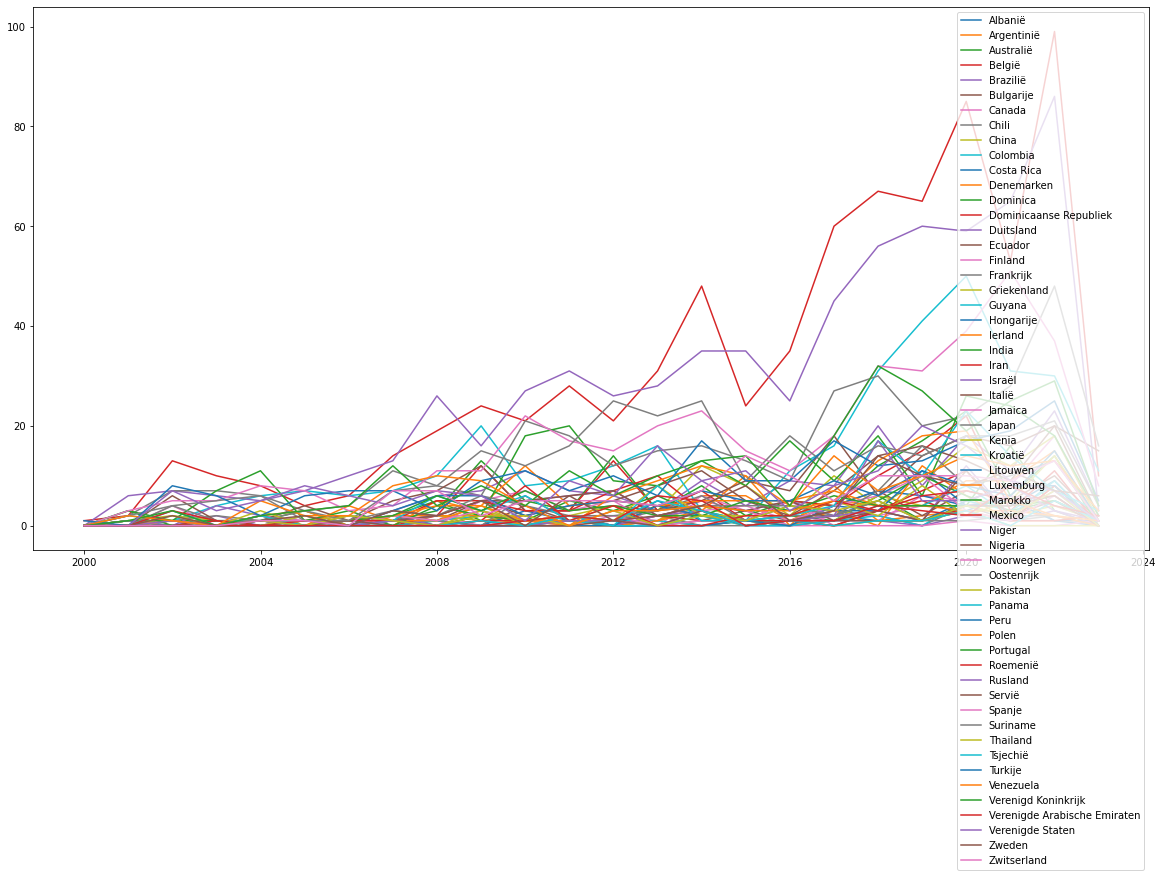

In [140]:
plt.rcParams["figure.figsize"] = (20,10)

complete_country_count_df = complete_country_count_df.fillna(0)
plt.plot(complete_country_count_df[20:])
plt.legend(complete_country_count_df.columns.tolist())
plt.show()

### TF-IDF / K means

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import numpy as np

documents = trafficking_df["case text"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
# vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)
vectorizer = TfidfVectorizer(min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)


X = vectorizer.fit_transform(documents)
X = X.astype('float32')

Create elbow curve to determine best k value

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


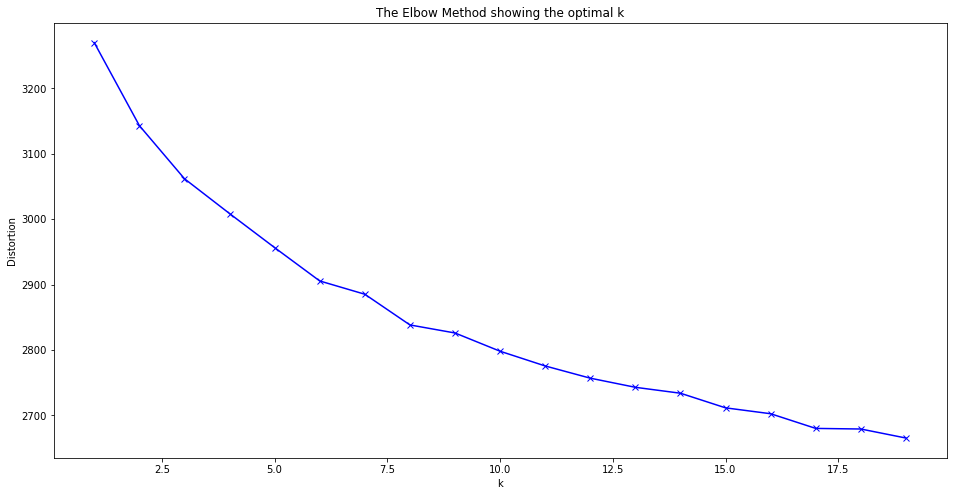

In [36]:
distortions = []
K = range(1,20)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

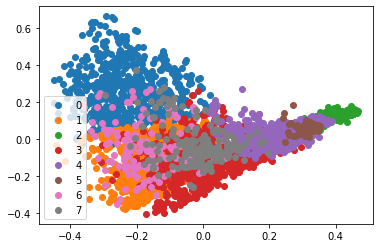

In [38]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [39]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(trafficking_df["K means cluster"].value_counts())

Top terms per cluster:
                 0               1                     2               3  \
0    medeverdachte       verdachte                 eiser       verdachte   
1        verdachte       rechtbank            verweerder             hof   
2             naam         cocaïne               besluit      betrokkene   
3        rechtbank            feit                eisers          beroep   
4              uur   medeverdachte             rechtbank   medeverdachte   
5           pagina         bewezen              gedaagde         cocaïne   
6   telefoonnummer             ten               artikel           hoger   
7          verbaal            naam                beroep             ten   
8          cocaïne        opiumwet             criterium         getuige   
9           proces        officier           gemachtigde          arrest   
10            zegt           laste                   awb         artikel   
11     organisatie        justitie            coffeeshop         

### 

### 

# NLP

### BERTje

In [54]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModel
import torch


#### Fill Mask

In [60]:
pipe = pipeline('fill-mask', model='GroNLP/bert-base-dutch-cased')

In [64]:
for res in pipe('Mijn naam is [MASK].'):
    print(res['sequence'])

Mijn naam is Robert.
Mijn naam is.
Mijn naam is Walter.
Mijn naam is Peter.
Mijn naam is Eric.


#### NER

In [63]:
nlp = pipeline('ner', model='wietsedv/bert-base-dutch-cased-finetuned-conll2002-ner')


In [65]:
example = "Mijn naam is Cas en mijn moeder heet Susanne en samen wonen wij in Griekenland"

ner_results = nlp(example)
ner_results

[{'entity': 'B-per',
  'score': 0.99999607,
  'index': 4,
  'word': 'Cas',
  'start': 13,
  'end': 16},
 {'entity': 'B-per',
  'score': 0.99999523,
  'index': 9,
  'word': 'Susanne',
  'start': 37,
  'end': 44},
 {'entity': 'B-loc',
  'score': 0.9999988,
  'index': 15,
  'word': 'Griekenland',
  'start': 67,
  'end': 78}]

In [72]:
trafficking_df.iloc[4]

case text            Parketnummer: 500.00072/18 Uitspraak: 29 juni ...
id                                              ECLI-NL-OGEAC-2018-352
jurisdiction_type                                       ['Strafrecht']
publication_date                                   2019-08-14 00:00:00
verdict_date                                       2018-06-29 00:00:00
verdict_type                                                 uitspraak
Name: 15, dtype: object

In [40]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = AutoModel.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

In [41]:
nlp = pipeline('ner', model=model, tokenizer=tokenizer)

The model 'RobertaModel' is not supported for ner. Supported models are ['YosoForTokenClassification', 'NystromformerForTokenClassification', 'QDQBertForTokenClassification', 'FNetForTokenClassification', 'LayoutLMv2ForTokenClassification', 'RemBertForTokenClassification', 'CanineForTokenClassification', 'RoFormerForTokenClassification', 'BigBirdForTokenClassification', 'ConvBertForTokenClassification', 'LayoutLMForTokenClassification', 'DistilBertForTokenClassification', 'CamembertForTokenClassification', 'FlaubertForTokenClassification', 'XLMForTokenClassification', 'XLMRobertaXLForTokenClassification', 'XLMRobertaForTokenClassification', 'LongformerForTokenClassification', 'RobertaForTokenClassification', 'SqueezeBertForTokenClassification', 'BertForTokenClassification', 'MegatronBertForTokenClassification', 'MobileBertForTokenClassification', 'XLNetForTokenClassification', 'AlbertForTokenClassification', 'ElectraForTokenClassification', 'FunnelForTokenClassification', 'MPNetForToke

In [42]:
example = "hallo mijn naam is cas"

ner_results = nlp(example)
ner_results

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyError: 38

### robBert

In [112]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [113]:
pipe = pipeline('fill-mask', model='pdelobelle/robbert-v2-dutch-base')

In [123]:
for res in pipe('Hallo, ik ben RobBERT, een <mask> taalmodel van de KU Leuven.'):
    print(res['sequence'])

Hallo, ik ben RobBERT, een Nederlands taalmodel van de KU Leuven.
Hallo, ik ben RobBERT, een Vlaams taalmodel van de KU Leuven.
Hallo, ik ben RobBERT, een Belgisch taalmodel van de KU Leuven.
Hallo, ik ben RobBERT, een nieuw taalmodel van de KU Leuven.
Hallo, ik ben RobBERT, een internationaal taalmodel van de KU Leuven.


In [126]:
ner = pipeline('ner', model='pdelobelle/robbert-v2-dutch-ner')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Exception: Error while initializing BPE: Token `Ċ` out of vocabulary

In [128]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-ner")

model = AutoModelForTokenClassification.from_pretrained("pdelobelle/robbert-v2-dutch-ner")
ner = pipeline(model=model, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Exception: Error while initializing BPE: Token `Ċ` out of vocabulary

In [127]:
ner("Hallo mijn naam is Cas.")

[{'entity': 'LABEL_0',
  'score': 0.6256969,
  'index': 1,
  'word': 'Hallo',
  'start': 0,
  'end': 5},
 {'entity': 'LABEL_0',
  'score': 0.5496396,
  'index': 2,
  'word': 'Ġmijn',
  'start': 6,
  'end': 10},
 {'entity': 'LABEL_0',
  'score': 0.66347605,
  'index': 3,
  'word': 'Ġnaam',
  'start': 11,
  'end': 15},
 {'entity': 'LABEL_0',
  'score': 0.59176594,
  'index': 4,
  'word': 'Ġis',
  'start': 16,
  'end': 18},
 {'entity': 'LABEL_0',
  'score': 0.60789007,
  'index': 5,
  'word': 'ĠCas',
  'start': 19,
  'end': 22},
 {'entity': 'LABEL_0',
  'score': 0.6715431,
  'index': 6,
  'word': '.',
  'start': 22,
  'end': 23}]

# B

In [10]:
selected_case = merged_df[merged_df['id'] == "ECLI-NL-GHARN-2004-AO7555"].iloc[0]

In [11]:
case_text = selected_case['case text']

In [12]:
print(case_text)



Parketnummer:	21-002321-02 
Uitspraak dd.:	13 februari 2004
TEGENSPRAAK
 
Gerechtshof te Arnhem  
meervoudige kamer voor strafzaken 
Arrest 
gewezen op het hoger beroep ingesteld tegen het vonnis van de meervoudige kamer van de rechtbank te Almelo van 3 september 2002 in de strafzaak tegen 

[verdachte]
geboren te [geboorteplaats] op [geboortedatum].
 
Het hoger beroep 
De verdachte heeft tegen voormeld vonnis hoger beroep ingesteld. 
Onderzoek van de zaak 

Dit arrest is gewezen naar aanleiding van het onderzoek op de terechtzitting van het hof van 30 januari 2004 en overeenkomstig het bepaalde bij artikel 422 van het Wetboek van Strafvordering het onderzoek op de terechtzitting in eerste aanleg.
Het hof heeft kennisgenomen van de vordering van de advocaat-generaal (zie voor de inhoud van de vordering bijlage I) na voorlezing aan het hof overgelegd en van hetgeen door en namens de verdachte naar voren is gebracht.
 
De gevoerde verweren 
Door de verdediging is aangevoerd dat door he

In [13]:
case_text.split('. ')

58

In [20]:
import nltk.data
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\casbe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [31]:

tokenizer = nltk.data.load('tokenizers/punkt/dutch.pickle')
sentence_list = tokenizer.tokenize(case_text)


In [41]:
word_list = ['cocaïne', 'albanië', 'duitsland', 'italië']

In [51]:

filtered_list = []
for sentence in sentence_list:
    if any(word in sentence for word in word_list):
#         filtered_list.append(sentence.split('. '))
        for i in sentence.split('. '):
            filtered_list.append(i)
        
print(len(filtered_list))

4


In [52]:
print(filtered_list)

['De telastelegging \nAan verdachte is telastegelegd zoals deze telastelegging in hoger beroep is gewijzigd dat: \n\n1.\nhij in of omstreeks de periode van 1 januari 2001 tot en met 19 januari 2002 te Hengelo (O) en/althans elders in Nederland tezamen en in vereniging met een ander althans alleen meermalen althans eenmaal (telkens) opzettelijk buiten het grondgebied van Nederland heeft gebracht hoeveelheden/een hoeveelheid van een materiaal bevattende heroïne (diacetylmorfine) en/of een hoeveelheid van een materiaal bevattende cocaïne en/of een hoeveelheid XTC-pillen in elk geval een hoeveelheid van een materiaal bevattende MDA en/of MDMA en/of MDEA zijnde heroïne en/of cocaïne en/of MDA/MDMA/MDEA een middel vermeld op de bij de Opiumwet behorende lijst I dan wel aangewezen krachtens het tweede of derde lid van artikel 2 van die wet te weten:\n- op of omstreeks 18 januari 2002 te Hengelo (O) althans in arrondissement (ongeveer) een hoeveelheid (ongeveer 3 kilogram althans 1953 gram) co

In [85]:
import re

text = "python is, an easy;language; to, learn."
print(re.split(';|, ', text))

['python is', 'an easy', 'language', ' to', 'learn.']
